In [2]:
from PIL import Image,  ImageDraw
import numpy as np
import math
import heapq
import matplotlib.pyplot as plt
from Kalman import ekf
import time
from local_nav import check_sides

In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

# Global Map 

In [ ]:
map = "./img/map2.png"

In [ ]:
def convert_image_to_binary_array(image_path,target_size=(1091, 772)):
    # Load the image
    image = Image.open(image_path)

    resized_image = image.resize(target_size)

    # Convert the image to grayscale
    resized_image = resized_image.convert("L")

    # Set the binary threshold
    binary_threshold = 128

    # Convert grayscale to binary image
    bw_image = resized_image.point(lambda p: p < binary_threshold and 1)

    # Convert image to numpy array
    binary_matrix = np.array(bw_image)
    return binary_matrix , resized_image

In [ ]:
class NODE:
    def __init__(self, position, g=float('inf'), h=0, parent=None):
        self.position = position
        self.g = g
        self.h = h
        self.f = g + h
        self.parent = parent

    # Nodes will be compared based on their f value, we use this because of the heapq
    def __lt__(self, other):
        return self.f < other.f

    # Function to represent the node
    def __repr__(self):
        return f"Node(position={self.position}, g={self.g}, h={self.h}, f={self.f})"

    @staticmethod
    def reconstruct_path(node):
        path = []
        while node:
            path.append(node.position)
            node = node.parent
        return path[::-1]


# Heuristic function using Octile distance (allowing 8 directions of movement)
def Heuristic_function(node, goal):
    dx = abs(node.position[0] - goal.position[0])
    dy = abs(node.position[1] - goal.position[1])
    return max(dx, dy) + (math.sqrt(2) - 1) * min(dx, dy)

def A_star(environment_map, START_POSITION, GOAL_POSITION):

    START_NODE = NODE(START_POSITION, g=0)
    GOAL_NODE = NODE(GOAL_POSITION)

    START_NODE.h = Heuristic_function(START_NODE, GOAL_NODE)
    START_NODE.f = START_NODE.g + START_NODE.h

    # Initialize the open and closed lists
    OPEN_list = []
    heapq.heappush(OPEN_list, START_NODE)
    CLOSED_set = set()

    # Dictionary to keep track of nodes
    nodes = {}
    nodes[tuple(START_NODE.position)] = START_NODE

    while OPEN_list:
        # Pop the node with the lowest f value
        CURRENT_NODE = heapq.heappop(OPEN_list)

        # If the current node is in the closed set, skip it
        if tuple(CURRENT_NODE.position) in CLOSED_set:
            continue

        # Add the current node's position to the closed set
        CLOSED_set.add(tuple(CURRENT_NODE.position))

        # If the current node is the goal, reconstruct the path
        if CURRENT_NODE.position == GOAL_NODE.position:
            path = NODE.reconstruct_path(CURRENT_NODE)
            print("Path found:", path)
            return path

        # Possible moves: 8 directions (including diagonals)
        MOVES = [[1, 0], [0, 1], [-1, 0], [0, -1],
                 [1, 1], [-1, -1], [1, -1], [-1, 1]]

        # Explore neighbors
        for move in MOVES:
            neighbor_position = [CURRENT_NODE.position[0] + move[0],
                                 CURRENT_NODE.position[1] + move[1]]
            neighbor_pos = tuple(neighbor_position)

            # Skip if out of bounds or obstacle
            if (neighbor_position[0] < 0 or neighbor_position[0] >= environment_map.shape[0] or
                neighbor_position[1] < 0 or neighbor_position[1] >= environment_map.shape[1] or
                environment_map[neighbor_position[0], neighbor_position[1]] == 1):
                continue

            # Skip if in closed set
            if neighbor_pos in CLOSED_set:
                continue

            # Calculate movement cost (diagnoal movement cost is sqrt(2))
            dx = abs(move[0])
            dy = abs(move[1])
            movement_cost = math.sqrt(2) if dx == 1 and dy == 1 else 1

            g_tentative = CURRENT_NODE.g + movement_cost

            # Create or get the neighbor node
            if neighbor_pos not in nodes:
                neighbor_node = NODE(neighbor_position)
                nodes[neighbor_pos] = neighbor_node
            else:
                neighbor_node = nodes[neighbor_pos]

            # If this path to neighbor is better, record it
            if g_tentative < neighbor_node.g:
                neighbor_node.g = g_tentative
                neighbor_node.h = Heuristic_function(neighbor_node, GOAL_NODE)
                neighbor_node.f = neighbor_node.g + neighbor_node.h
                neighbor_node.parent = CURRENT_NODE

                # Add the neighbor to the open list
                heapq.heappush(OPEN_list, neighbor_node)

    print("No path found.")
    return None

In [ ]:
binary_matrix , resized_image = convert_image_to_binary_array(map)
# Start and goal positions
START_POSITION = [5, 5]
GOAL_POSITION = [760, 1080]

path = A_star(binary_matrix, START_POSITION, GOAL_POSITION)


In [ ]:
# Display the binary map with start and goal points
plt.figure(figsize=(10, 10))
plt.imshow(binary_matrix, cmap="gray")
plt.scatter(START_POSITION[1], START_POSITION[0], color='green', s=100, label="Start")  # Green for Start
plt.scatter(GOAL_POSITION[1], GOAL_POSITION[0], color='red', s=100, label="Goal")  # Red for Goal
plt.title("Binary Map with Start and Goal")
plt.legend()
plt.axis("off")
plt.show()


PIL and Matplotlib have different systems of coordinates. Pillow treats the top-left corner as (0,0), and coordinates increase downwards and rightwards.While for Matplotlib displays images as NumPy arrays, where the origin is at the bottom-left corner, and the y-axis is flipped compared to Pillow.

In [ ]:
def swap_path_coordinates(path_coordinates):
    swapped_path = [[y, x] for x, y in path_coordinates]
    return swapped_path

def display_path(maze_img, path):

    # Convert the maze image to RGB (to draw in color)
    maze_img = maze_img.convert("RGB")

    # Swap path coordinates to match PIL's (x, y) format
    path = swap_path_coordinates(path)

    # Create a drawing object
    draw = ImageDraw.Draw(maze_img)

    # Draw the path (magenta line)
    for i in range(len(path) - 1):
        x1, y1 = path[i]
        x2, y2 = path[i + 1]
        draw.line((x1, y1, x2, y2), fill=(255, 0, 255), width=4)  # Magenta line with width 4

    # Save the modified image (optional)
    #maze_img.save("maze_with_path_fixed.png")

    # Display the image using Matplotlib
    maze_array = np.array(maze_img)  # Convert to NumPy array for Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(maze_array)
    plt.axis("off")
    plt.title("Maze with Path (Jupyter Notebook)")
    plt.show()

display_path(resized_image, path)

In [ ]:
def segment_path(path, step=10):
    """
    Segments the A* path into waypoints for the motion controller.

    Parameters:
    - path: List of (row, column) points from the A* algorithm.
    - step: Number of points to skip between waypoints.

    Returns:
    - waypoints: List of (x, y) waypoints in meters.
    """
    waypoints = path[::step]  # Take every `step`-th point
    waypoints.append(path[-1])  # Ensure the last point (goal) is included
    return waypoints

def grid_to_world_coordinates(waypoints, map_resolution, origin=(0, 0)):
    """
    Converts waypoints from grid coordinates to world coordinates.

    Parameters:
    - waypoints: List of (row, col) waypoints in grid coordinates.
    - map_resolution: Size of each grid cell in meters.
    - origin: World coordinates of the grid's (0, 0).

    Returns:
    - world_waypoints: List of (x, y) waypoints in meters.
    """
    world_waypoints = [
        (origin[0] + w[1] * map_resolution, origin[1] + w[0] * map_resolution) for w in waypoints
    ]
    return world_waypoints


In [ ]:
waypoints = segment_path(path, step=40) 
map_resolution = 0.05  
origin = (0, 0)
world_waypoints = grid_to_world_coordinates(waypoints, map_resolution, origin)

In [ ]:
path = np.array(path)
plt.plot(path[:, 1], path[:, 0], label="A* Path", color="pink")

waypoints = np.array(waypoints)
plt.scatter(waypoints[:, 1], waypoints[:, 0], color="blue", label="Waypoints", zorder=3)

plt.gca().invert_yaxis()  
plt.legend()
plt.title("Path Segmentation for Motion Control")
plt.xlabel("Grid Columns")
plt.ylabel("Grid Rows")
plt.grid()
plt.show()


# Motion Control 

## Testing some things on thymio: 

In [ ]:
!pip install --upgrade tdmclient

In [ ]:
# Robot-specific constants
ROBOT_CENTER_TO_WHEEL = 47.5  # Half the wheelbase mm
ROBOT_WHEEL_RADIUS = 22    # Radius of the wheels mm
SPEED_THRESHOLD = 100         # Max Thymio wheel speed

# Normalize angle to (-pi, pi)
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

# Astolfi Controller for Thymio
def astolfi_controller(state, goal, kr= 0.8, ka=  1.2,  goal_tolerance=20):
    #alpha doit etre plus grand que rho pour Julien 
    
    x = state[0] #en mm 
    y = state[1] #en mm 
    theta = state[2]
    x_goal, y_goal = goal
    dx = x_goal - x
    dy = y_goal - y
    rho = np.sqrt(dx**2 + dy**2)  # Distance to goal

    print ("Distance to goal = " , rho )
    alpha = normalize_angle(np.arctan2(dy, dx) - theta)
    #beta = normalize_angle(- theta - alpha)
    # Stop if the robot is close enough to the goal
    if rho < goal_tolerance:
        return 0.0, 0.0, True
    # Control laws
    v = kr * rho #kr > 0 
    #v = max(kr * rho, MIN_SPEED) 
    omega = ka * alpha 
    return v, omega, False


# Convert velocities to motor speeds
def compute_motor_speeds(v, omega):

    # Convert speed thresholds for clipping
    max_v = SPEED_THRESHOLD * 0.388  # Max linear velocity in mm/s
    max_omega = max_v / ROBOT_CENTER_TO_WHEEL  # Max angular velocity in rad/s

    v = np.clip(v, -max_v, max_v) #actul control velocity given to the thymio 
    omega = np.clip(omega, -max_omega, max_omega)

    right_wheel_mm_s = (v + omega * ROBOT_CENTER_TO_WHEEL)  # mm/s
    left_wheel_mm_s = (v - omega * ROBOT_CENTER_TO_WHEEL)  # mm/s

    thymio_speed_to_mms = 0.388
    right_wheel_enc = np.clip(right_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)
    left_wheel_enc = np.clip(left_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)

    # Debugging outputs
    #print(f"Clipped control inputs: v = {v}, omega = {omega}")
    #print(f"left wheel control speed = {left_wheel_enc}, right wheel control speed = {right_wheel_enc}")

    return int(left_wheel_enc), int(right_wheel_enc) , v , omega 


## TEST 

In [4]:
#fonctions de Julie 
@tdmclient.notebook.sync_var 
def set_speed(right_speed,left_speed):
    global motor_right_target, motor_left_target
    motor_right_target=right_speed
    motor_left_target=left_speed

@tdmclient.notebook.sync_var
def stop_thymio():
    global motor_right_target,motor_left_target
    motor_right_target=0
    motor_left_target=0

@tdmclient.notebook.sync_var
def get_speed():
    global motor_right_speed, motor_left_speed
    return motor_right_speed,motor_left_speed

def speed_convesion(r_speed,l_speed):
    thymio_speed_to_mms = 0.388 # value found in covariance_estimation

    #odometry 
    avg_thymio_speed = (r_speed + l_speed) / 2
    speed = avg_thymio_speed * thymio_speed_to_mms # [mm/s]
    return speed

def angular_vel_conversion(r_speed,l_speed):
    d = 95 # distance between the 2 wheels [mm]
    thymio_speed_to_mms = 0.388 # value found in covariance_estimation
    
    difference_speed = l_speed - r_speed
    omega = difference_speed * thymio_speed_to_mms / d # [rad/s]

    return omega


In [ ]:
set_speed(100, -200)
time.sleep(0.5)
stop_thymio()

In [ ]:
stop_thymio()

In [ ]:
def move_to_waypoint(state, waypoint, goal_tolerance=20):
    # Astolfi controller to compute control signals
    v, omega, reached = astolfi_controller(state, waypoint, goal_tolerance=goal_tolerance)
    if reached:
        return 0, 0, True , 0 ,0
    # Convert control signals to motor speeds
    left_speed, right_speed ,v_f , omega_f = compute_motor_speeds(v, omega)
    return left_speed, right_speed, False , v_f , omega_f  #in Thymio's units 


In [ ]:
stop_thymio()

In [ ]:
#pour tester
#waypoints = [(70, 300), (98, 236), (126, 172), (153, 107), (181, 43), (209, -21), (237, -85), (265, -150), (293, -214), (320, -278), (348, -342), (376, -407), (404, -471), (432, -535), (460, -599)]

waypoints =  [
    (0.0, 0.0),
    (69.7, 1.6),
    (138.2, 13.1),
    (204.1, 34.2),
    (265.9, 64.3),
    (322.2, 102.5),
    (371.6, 147.6),
    (413.0, 198.3),
    (445.3, 253.3),
    (467.5, 311.2)
]

# Initial state [x, y, theta]
state_est=[0,0,0,0,0] 
P_est=np.diag([0.1,0.1,0.1,0.1,0.1])
goal_tolerance = 30

obs_camera=[np.nan,np.nan,np.nan]
camera_state=False

# Logging data
trajectory = []  # To store [x, y] positions
trajectory = []  # Logs (x, y) positions
metrics_rho = []  # Logs for distance to goal
metrics_alpha = []  # Logs for angle to goal

time_prev = time.time()

# Start motion
for waypoint in waypoints:
    print("Goal" , waypoint)
    reached = False
    while not reached:
        actual_time = time.time()
        Ts = actual_time - time_prev
        if Ts < 0.15:
            time.sleep(0.15-Ts)
        time_prev = actual_time
        # Move towards the waypoint
        input_left_speed, input_right_speed, reached , v_f , omega_f  = move_to_waypoint(state_est, waypoint, goal_tolerance)

        set_speed(input_right_speed, input_left_speed)
        # Get current odometry data
        r_speed_odo, l_speed_odo = get_speed()
        actual_v = speed_convesion(r_speed_odo, l_speed_odo)
        actual_w = angular_vel_conversion(r_speed_odo, l_speed_odo)
        obs_odometry = [actual_v, actual_w]

        # Control input
        input_v = v_f #Ca jsp si je remplace par actual_v et actual_w
        input_w = omega_f
        control_vect_prev = [input_v, input_w]

        # Update state with Kalman filter
        state_est, P_est = ekf(state_est, control_vect_prev, P_est, obs_camera, obs_odometry, camera_state,Ts)
        # Log trajectory
        trajectory.append((state_est[0], state_est[1]))
        
        # Calculate and log metrics
        rho = np.sqrt((waypoint[0] - state_est[0])**2 + (waypoint[1] - state_est[1])**2)
        alpha = normalize_angle(np.arctan2(waypoint[1] - state_est[1], waypoint[0] - state_est[0]) - state_est[2])
        metrics_rho.append(rho)
        metrics_alpha.append(alpha)
        # Print updated state
        print(f"Position Actuelle odometry: x = {state_est[0]}, y = {state_est[1]}, theta = {state_est[2]}") 

    # Stop the robot at the waypoint
    stop_thymio()
    print(f"Reached waypoint: {waypoint}")

print("Trajectory completed!")


In [ ]:
# Plot the robot's final trajectory
plt.figure(figsize=(10, 6))
plt.title("Robot Trajectory")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
x_coords, y_coords = zip(*trajectory)
plt.plot(x_coords, y_coords, 'b-', label="Trajectory")
plt.scatter(*zip(*waypoints), c='r', label="Waypoints")
plt.legend()
plt.grid()
plt.show()

# Plot metrics (rho and alpha) over time
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(metrics_rho, 'g-', label="Distance to Goal (rho)")
plt.xlabel("Time Steps")
plt.ylabel("Distance (mm)")
plt.title("Distance to Goal (rho)")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(metrics_alpha, 'r-', label="Angle to Goal (alpha)")
plt.xlabel("Time Steps")
plt.ylabel("Angle (radians)")
plt.title("Angle to Goal (alpha)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
stop_thymio()

### Adding Simple Local Nav: 

In [5]:
@tdmclient.notebook.sync_var
def get_proximity_values():
    global prox_horizontal
    prox = prox_horizontal
    prox_front = prox[2]
    prox_left = prox[0]
    prox_left_front = prox[1]
    prox_right_front = prox[3]
    prox_right = prox[4]
    return prox_front, prox_left, prox_left_front, prox_right_front, prox_right

In [ ]:
stop_thymio()

In [ ]:
set_speed(-100,100)

In [ ]:
#ligne droite distance 70 mm entre waypoints
""" waypoints =  [
    (0.0, 0.0),
    (69.7, 1.6),
    (138.2, 13.1),
    (204.1, 34.2),
    (265.9, 64.3),
    (322.2, 102.5),
    (371.6, 147.6),
    (413.0, 198.3),
    (445.3, 253.3),
    (467.5, 311.2)
] """
#Straight trajectory 
waypoints = [
    (0.0, 0.0),
    (70.0, 0.0),
    (140.0, 0.0),
    (210.0, 0.0),
    (280.0, 0.0),
    (350.0, 0.0),
    (420.0, 0.0),
    (490.0, 0.0),
    (560.0, 0.0),
    (630.0, 0.0)
]


# Initial state [x, y, theta]
state_est=[0,0,0,0,0] 
P_est=np.diag([0.1,0.1,0.1,0.1,0.1])
goal_tolerance = 30

obs_camera=[np.nan,np.nan,np.nan]
camera_state=False

obstSpeedGain = [2, 1, -1, -1.5, -2.5]  # Gains for obstacle avoidance
OBSTACLE_THRESH_LOW_FRONT = 8 # Threshold to stop avoiding
OBSTACLE_THRESH_HIGH_FRONT = 15 # Threshold to start avoiding
thymio_state = 0  # 0 = Goal tracking, 1 = Obstacle avoidance

# Logging data
trajectory = []  # To store [x, y] positions
trajectory = []  # Logs (x, y) positions
metrics_rho = []  # Logs for distance to goal
metrics_alpha = []  # Logs for angle to goal

#logging pour local nav 
left_speeds = []  # Logs left wheel speeds 
right_speeds = []  # Logs right wheel speeds
proximity_sensor_data = [] 
thymio_modes = []

time_prev = time.time()

# Start motion
for waypoint in waypoints:
    print("GOAL " , waypoint)
    reached = False
    while not reached:
        actual_time = time.time()
        Ts = actual_time - time_prev
        if Ts < 0.15:
            time.sleep(0.15-Ts)
        time_prev = actual_time

        prox_front, prox_left, prox_left_front, prox_right_front, prox_right = get_proximity_values()
        proximity_values = [prox_left, prox_left_front, prox_front, prox_right_front, prox_right]
    
        # Check for obstacle state transitions
        if thymio_state == 0:
        # Switch to obstacle avoidance if an obstacle is detected
            if any((prox // 100) > OBSTACLE_THRESH_HIGH_FRONT for prox in proximity_values) :
                thymio_state = 1
        elif thymio_state == 1:
        # Switch back to goal tracking if obstacles are cleared
            if all((prox // 100) < OBSTACLE_THRESH_LOW_FRONT for prox in proximity_values):
                print("Obstacle avoided")
                #set_speed(20, 20)  #Continue getting away from obstacle for a short time ?   
                #stop_thymio() #idk if i keep it 
                thymio_state = 0
                break #to go to next waypoint
        if thymio_state == 0:
            # Goal tracking
            print("Goal tracking :", waypoint)
             # Move towards the waypoint
            input_left_speed, input_right_speed, reached , v_f , omega_f  = move_to_waypoint(state_est, waypoint, goal_tolerance)
            set_speed(input_right_speed, input_left_speed)
        else:
            # Obstacle avoidance
            print("Obstacle detected !! ")
            turning_decision = check_sides(state_est,global_map , visibility_range= 70)
            if (turning_decision == True ): 
                #Turning right 
                set_speed(-100,100)
                time.sleep(0.4)
                set_speed(50,50)
                time.sleep(0.3)
                set_speed(100,-100)
                time.sleep(0.4)
                set_speed(50,50)
                time.sleep(0.3)
                stop_thymio()



    
            #time.sleep(0.3) 
            input_left_speed = int(spLeft)
            input_right_speed = int(spRight)
            #left_speeds.append(input_left_speed)  # Append left wheel speed
            #right_speeds.append(input_right_speed)  
            input_right_speed = int(np.clip(input_right_speed, -100, 100))
            input_left_speed = int(np.clip(input_left_speed, -100, 100))
            set_speed(input_right_speed, input_left_speed)
            #time.sleep(0.02)
            print( "PR =" , prox_right//100 , "PRF :" , prox_right_front//100 , "PF : ", prox_front//100)
            print( "PL =" , prox_left//100 , "PLF :" , prox_left_front//100 )
            print("Left Speed OA:", input_left_speed)
            print("Right Speed OA:", input_right_speed)


            #time.sleep(0.15)
        
        # Get current odometry data
        r_speed_odo, l_speed_odo = get_speed()
        actual_v = speed_convesion(r_speed_odo, l_speed_odo)
        
        actual_w = angular_vel_conversion(r_speed_odo, l_speed_odo)
        obs_odometry = [actual_v, actual_w]

        # Control input
        input_v = v_f #Ca jsp si je remplace par actual_v et actual_w
        input_w = omega_f
        control_vect_prev = [input_v, input_w]

        # Update state with Kalman filter
        state_est, P_est = ekf(state_est, control_vect_prev, P_est, obs_camera, obs_odometry, camera_state,Ts)
        # Log trajectory
        trajectory.append((state_est[0], state_est[1]))
        thymio_modes.append(thymio_state)
        
        # Calculate and log metrics
        rho = np.sqrt((waypoint[0] - state_est[0])**2 + (waypoint[1] - state_est[1])**2)
        alpha = normalize_angle(np.arctan2(waypoint[1] - state_est[1], waypoint[0] - state_est[0]) - state_est[2])
        metrics_rho.append(rho)
        metrics_alpha.append(alpha)
       

    # Stop the robot at the waypoint
    stop_thymio()
    print(f"Reached waypoint: {waypoint}")

print("Trajectory completed!")

In [ ]:
set_speed(-100,100)
time.sleep(1.5)
set_speed(70,70)
time.sleep(3)
set_speed(100,-100)
time.sleep(1.5)
set_speed(70,70)
time.sleep(3)
stop_thymio()

In [ ]:
import matplotlib.pyplot as plt

# Extract trajectory and waypoints
x_traj, y_traj = zip(*trajectory)
x_waypoints, y_waypoints = zip(*waypoints)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(x_traj, y_traj, label="Trajectory", linewidth=2)
plt.scatter(x_waypoints, y_waypoints, color='red', label="Waypoints", zorder=5)
plt.title("Robot Trajectory and Waypoints")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid()

plt.show()


In [ ]:

# Convert proximity sensor data into separate lists
prox_left, prox_left_front, prox_front, prox_right_front, prox_right = zip(*proximity_sensor_data)

time_steps = range(len(left_speeds))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis for sensor values
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Proximity Sensor Values", color='tab:blue')
ax1.plot(time_steps, prox_left, label="Prox Left", linestyle='--', color='tab:blue')
ax1.plot(time_steps, prox_left_front, label="Prox Left Front", linestyle='--', color='tab:cyan')
ax1.plot(time_steps, prox_front, label="Prox Front", linestyle='--', color='tab:green')
ax1.plot(time_steps, prox_right_front, label="Prox Right Front", linestyle='--', color='tab:orange')
ax1.plot(time_steps, prox_right, label="Prox Right", linestyle='--', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")
ax1.grid()

# Secondary y-axis for left wheel speed
ax2 = ax1.twinx()
ax2.set_ylabel("Left Wheel Speed", color='tab:purple')
ax2.plot(time_steps, left_speeds, label="Left Wheel Speed", linewidth=2, color='tab:purple')
ax2.tick_params(axis='y', labelcolor='tab:purple')
ax2.legend(loc="upper right")

# Title and layout
plt.title("Proximity Sensor Values vs. Left Wheel Speed")
fig.tight_layout()
plt.show()


fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis for sensor values
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Proximity Sensor Values", color='tab:blue')
ax1.plot(time_steps, prox_left, label="Prox Left", linestyle='--', color='tab:blue')
ax1.plot(time_steps, prox_left_front, label="Prox Left Front", linestyle='--', color='tab:cyan')
ax1.plot(time_steps, prox_front, label="Prox Front", linestyle='--', color='tab:green')
ax1.plot(time_steps, prox_right_front, label="Prox Right Front", linestyle='--', color='tab:orange')
ax1.plot(time_steps, prox_right, label="Prox Right", linestyle='--', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")
ax1.grid()

# Secondary y-axis for right wheel speed
ax2 = ax1.twinx()
ax2.set_ylabel("Right Wheel Speed", color='tab:purple')
ax2.plot(time_steps, right_speeds, label="Right Wheel Speed", linewidth=2, color='tab:purple')
ax2.tick_params(axis='y', labelcolor='tab:purple')
ax2.legend(loc="upper right")

# Title and layout
plt.title("Proximity Sensor Values vs. Right Wheel Speed")
fig.tight_layout()
plt.show()



In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))

# Primary y-axis for sensor values
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Proximity Sensor Values", color='tab:blue')
ax1.plot(time_steps, prox_left, label="Prox Left", linestyle='--', color='tab:blue')
ax1.plot(time_steps, prox_left_front, label="Prox Left Front", linestyle='--', color='tab:cyan')
ax1.plot(time_steps, prox_front, label="Prox Front", linestyle='--', color='tab:green')
ax1.plot(time_steps, prox_right_front, label="Prox Right Front", linestyle='--', color='tab:orange')
ax1.plot(time_steps, prox_right, label="Prox Right", linestyle='--', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")
ax1.grid()

# Secondary y-axis for wheel speeds
ax2 = ax1.twinx()
ax2.set_ylabel("Wheel Speeds", color='tab:purple')
ax2.plot(time_steps, left_speeds, label="Left Wheel Speed", linewidth=2, color='tab:purple')
ax2.plot(time_steps, right_speeds, label="Right Wheel Speed", linewidth=2, color='tab:pink')
ax2.tick_params(axis='y', labelcolor='tab:purple')
ax2.legend(loc="upper right")

# Title and layout
plt.title("Proximity Sensor Values vs. Wheel Speeds")
fig.tight_layout()
plt.show()



In [ ]:
stop_thymio()

## simulation calcul thymio pour alpha et beta: 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Constants for Thymio speed computation
SPEED_THRESHOLD = 100  # Max Thymio speed
ROBOT_CENTER_TO_WHEEL = 47.5  # Distance from the center to each wheel in mm

def compute_motor_speeds(v, omega):
    # Convert speed thresholds for clipping
    max_v = SPEED_THRESHOLD * 0.388  # Max linear velocity in mm/s
    max_omega = max_v / ROBOT_CENTER_TO_WHEEL  # Max angular velocity in rad/s

    v = np.clip(v, -max_v, max_v)  # Actual control velocity given to the Thymio
    omega = np.clip(omega, -max_omega, max_omega)

    right_wheel_mm_s = (v + omega * ROBOT_CENTER_TO_WHEEL)  # mm/s
    left_wheel_mm_s = (v - omega * ROBOT_CENTER_TO_WHEEL)  # mm/s

    thymio_speed_to_mms = 0.388
    right_wheel_enc = np.clip(right_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)
    left_wheel_enc = np.clip(left_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)

    return int(left_wheel_enc), int(right_wheel_enc), v, omega

def astolfi_simulation_with_speeds(initial_state, goal, goal_tolerance, k_alpha, k_rho, time_step=0.15, max_iterations=100):
    # Initialize variables
    x, y, theta = initial_state
    x_goal, y_goal = goal
    trajectory = [(x, y, theta)]  # To store the robot's path
    iterations = 0
    motor_speeds = []  # Store Thymio motor speeds
    times = []  # Store time for plotting
    rho = 0 

    while (iterations < max_iterations) or (rho < 30) :
        # Compute polar coordinates
        dx = x_goal - x
        dy = y_goal - y
        rho = math.sqrt(dx**2 + dy**2)
        alpha = math.atan2(dy, dx) - theta  # Orientation error

        # Normalize alpha to [-pi, pi]
        alpha = (alpha + math.pi) % (2 * math.pi) - math.pi

        # Check if goal is reached
        if rho < goal_tolerance:
            print("Success")
            break

        # Control laws
        v = k_rho * rho  # Linear velocity
        w = k_alpha * alpha  # Angular velocity

        # Compute Thymio motor speeds
        left_speed, right_speed, clipped_v, clipped_omega = compute_motor_speeds(v, w)
        motor_speeds.append((left_speed, right_speed))
        times.append(iterations * time_step)

        # Apply motion model
        x += clipped_v * math.cos(theta) * time_step
        y += clipped_v * math.sin(theta) * time_step
        theta += clipped_omega * time_step

        # Store results
        trajectory.append((x, y, theta))

        # Increment iteration
        iterations += 1

    return iterations, trajectory, motor_speeds, times


In [ ]:

# Example usage
initial_state = (0, 0, 0)  # Start at origin, facing right
goal = (70,70)   # Goal position
goal_tolerance = 10
k_alpha = 7 
k_rho = 0.8

iterations, trajectory, motor_speeds, times = astolfi_simulation_with_speeds(
    initial_state, goal, goal_tolerance, k_alpha, k_rho
)

# Plot motor speeds
left_speeds = [speed[0] for speed in motor_speeds]
right_speeds = [speed[1] for speed in motor_speeds]

plt.plot(times, left_speeds, label="Left Wheel Speed")
plt.plot(times, right_speeds, label="Right Wheel Speed")
plt.title("Thymio Motor Speeds Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Motor Speed (Thymio Units)")
plt.legend()
plt.grid()
plt.show()

print(f"Number of iterations to reach the goal: {iterations}")



In [ ]:
import matplotlib.pyplot as plt

trajectory_x = [pos[0] for pos in trajectory]
trajectory_y = [pos[1] for pos in trajectory]

plt.plot(trajectory_x, trajectory_y, marker="o")
plt.scatter([goal[0]], [goal[1]], color="red", label="Goal")
plt.title("Robot Trajectory")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

In [ ]:
stop_thymio()

## Local Nav last try: 

- Distance transform to check the nearest wall on the graph. How it works? 

    - 1 Precompute Distances: We precomputed the distance transform (dist_map) for the entire map.
    - 2 Left and Right Checks: Using the robot's position and orientation, we projected its left and right directions.
    - 3 For each direction, we looked up the corresponding distance in the dist_map.
Decision: We compared the distances for the left and right directions to decide which side is clearer (further from walls).

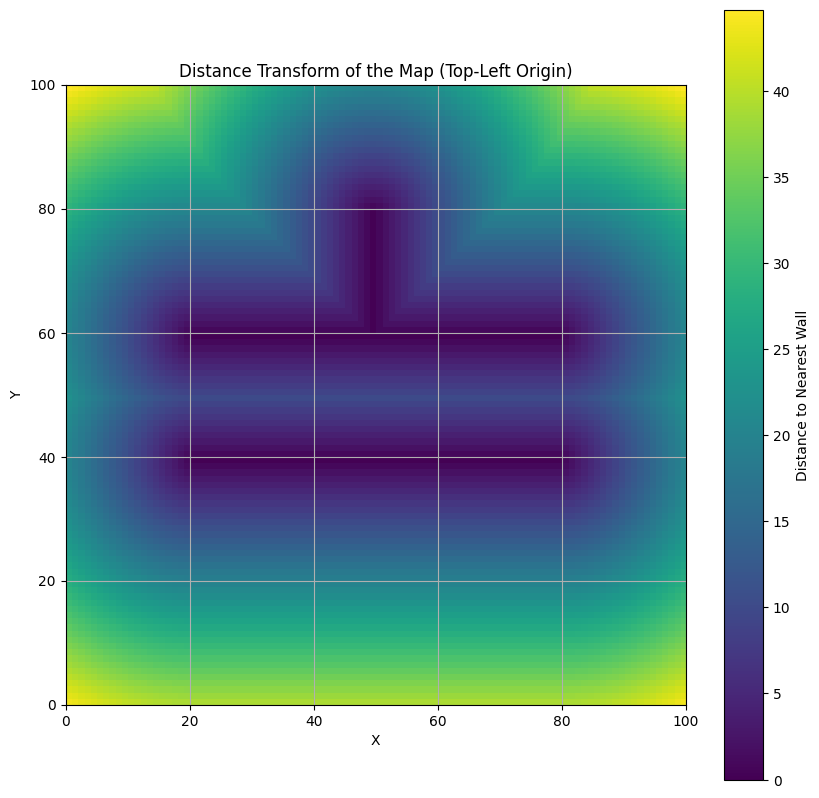

In [55]:
from scipy.ndimage import distance_transform_edt



# Define the global map for testing purposes
global_map = np.zeros((100, 100))  # Create an empty map
global_map[20:80, 40] = 1  
global_map[20:80, 60] = 1  # Vertical wall at x=60
global_map[50, 20:40] = 1  # Horizontal wall at y=50


# Compute the distance transform
dist_map = distance_transform_edt(global_map == 0)  # Distance from free space to walls

# Flip the distance map vertically for top-left origin like the camera! 
flipped_dist_map = np.flipud(dist_map)

# Plot the flipped distance transform
plt.figure(figsize=(10, 10))
plt.imshow(flipped_dist_map.T, origin='upper', cmap='viridis', extent=(0, 100, 0, 100))  # Flipped map
plt.colorbar(label="Distance to Nearest Wall")
plt.title("Distance Transform of the Map (Top-Left Origin)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()




In [57]:
print("Original Distance Map:")
print(dist_map[50:55, 20:25])  # Sample region
print("Flipped Distance Map:")
print(flipped_dist_map[50:55, 20:25])  # Sample region



Original Distance Map:
[[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4.]]
Flipped Distance Map:
[[1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5.]]


In [51]:
def check_sides(position, dist_map, max_visibility=50, step=5):
    """
    Dynamically increase the visibility range to check for walls in left and right directions.
    Stops and returns the decision as soon as a wall is encountered on either side.

    Args:
        position (tuple): (x, y, theta) position and orientation of the robot.
        dist_map (2D numpy array): Precomputed distance transform of the global map.
        max_visibility (int): Maximum range to check.
        step (int): Step size to increment the visibility range.

    Returns:
        decision (str): 'left' or 'right' depending on the clearer direction.
        left_distance (float): Distance at which the wall was encountered on the left.
        right_distance (float): Distance at which the wall was encountered on the right.
    """
    x, y, theta = position
    direction_vector = np.array([np.cos(theta), np.sin(theta)])
    left_normal = np.array([-direction_vector[1], direction_vector[0]])  # 90° counterclockwise
    right_normal = np.array([direction_vector[1], -direction_vector[0]])  # 90° clockwise

    visibility_range = 0
    left_distance = right_distance = max_visibility  # Default to max visibility if no wall is encountered

    while visibility_range < max_visibility:
        visibility_range += step

        # Project to left and right positions
        left_pos = (int(round(x + visibility_range * left_normal[0])),
                    int(round(y + visibility_range * left_normal[1])))
        right_pos = (int(round(x + visibility_range * right_normal[0])),
                     int(round(y + visibility_range * right_normal[1])))

        # Get distances from the distance transform (with bounds checking)
        left_dist = dist_map[min(max(left_pos[1], 0), dist_map.shape[0]-1),
                             min(max(left_pos[0], 0), dist_map.shape[1]-1)]
        right_dist = dist_map[min(max(right_pos[1], 0), dist_map.shape[0]-1),
                              min(max(right_pos[0], 0), dist_map.shape[1]-1)]

        # If a wall is encountered in either direction, stop and decide
        if left_dist < visibility_range:
            left_distance = left_dist
            return "right", left_distance, right_distance
        if right_dist < visibility_range:
            right_distance = right_dist
            return "left", left_distance, right_distance

    # If no walls encountered, choose based on max visibility distances
    return ("left" if left_distance > right_distance else "right"), left_distance, right_distance


Decision: right
Left distance: 10.0, Right distance: 50


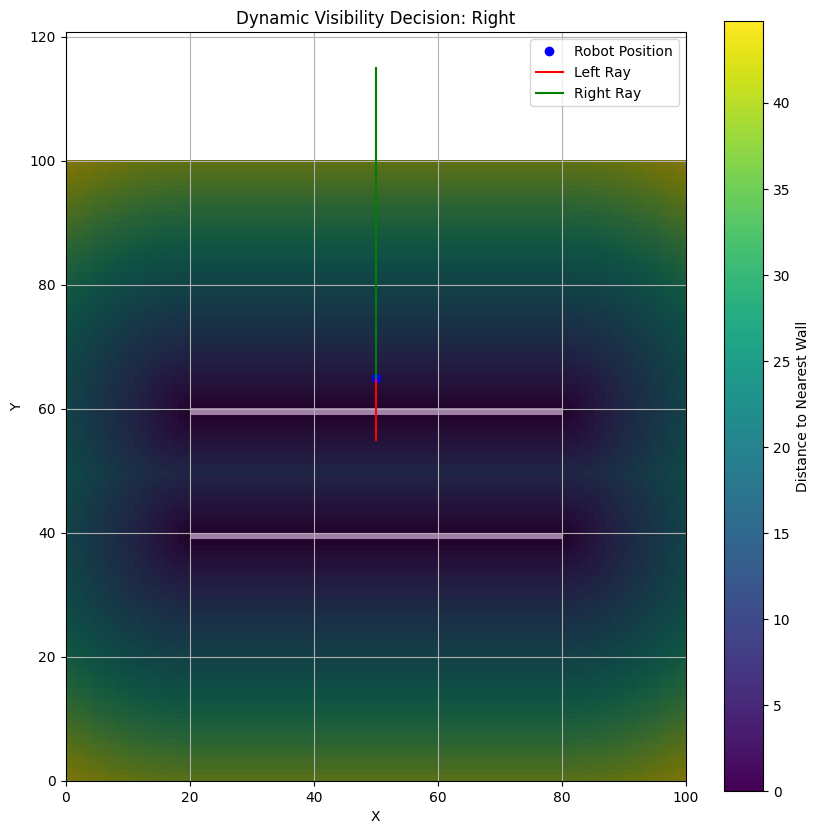

In [52]:
def visualize_dynamic_visibility(global_map, dist_map, position, decision, left_distance, right_distance):
    x, y, theta = position
    direction_vector = np.array([np.cos(theta), np.sin(theta)])
    left_normal = np.array([-direction_vector[1], direction_vector[0]])
    right_normal = np.array([direction_vector[1], -direction_vector[0]])

    # Flip y-coordinate for visualization
    flipped_y = dist_map.shape[0] - y

    # Plot the distance transform
    plt.figure(figsize=(10, 10))
    plt.imshow(dist_map.T, origin='upper', cmap='viridis', extent=(0, global_map.shape[1], 0, global_map.shape[0]))

    plt.colorbar(label="Distance to Nearest Wall")
    plt.title(f"Dynamic Visibility Decision: {decision.capitalize()}")

    # Overlay the walls
    plt.imshow(global_map.T, origin='upper', cmap='gray', alpha=0.5, extent=(0, global_map.shape[1], 0, global_map.shape[0]))

    # Plot robot position
    plt.plot(x, flipped_y, 'bo', label="Robot Position")

    # Plot left and right rays
    plt.plot([x, x + left_distance * left_normal[0]],
             [flipped_y, flipped_y - left_distance * left_normal[1]], 'r-', label="Left Ray")
    plt.plot([x, x + right_distance * right_normal[0]],
             [flipped_y, flipped_y - right_distance * right_normal[1]], 'g-', label="Right Ray")

    # Add legend and labels
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()


# Example Usage
robot_position = (50, 35, 0)  # (x, y, theta)
decision, left_distance, right_distance = check_sides(robot_position, dist_map, max_visibility=50, step=5)
print(f"Decision: {decision}")
print(f"Left distance: {left_distance}, Right distance: {right_distance}")

# Visualize the decision
visualize_dynamic_visibility(global_map, dist_map, robot_position, decision, left_distance, right_distance)



In [24]:
set_speed(-100,100)

In [25]:
stop_thymio()

In [ ]:
def dynamic_obstacle_avoidance(state , movement_duration=0.5):
    """
    Perform a reactive L-shaped maneuver for obstacle avoidance.
    Args:
        state (dict): Tracks the state of the maneuver phases.
        prox_values (list): Proximity sensor values [left, left-front, front, right-front, right].
        movement_duration (float): Base duration for each movement phase.
    Returns:
        bool: True if the maneuver is ongoing, False if completed.
    """
    current_time = time.time()

    # Phase 0: Start maneuver (fixed decision: right turn)
    if state["phase"] == 0:
        state["decision"] = "right"
        state["start_time"] = current_time
        state["phase"] = 1  

    # Phase 1: Turn away from the obstacle
    if state["phase"] == 1:
        if current_time - state["start_time"] < movement_duration:
            print("Phase 1: Turning away from the obstacle.")
            set_speed(-100, 100)  
        else:
            state["start_time"] = current_time
            state["phase"] = 2

    # Phase 2: Move forward to clear the obstacle
    elif state["phase"] == 2:
        if current_time - state["start_time"] < movement_duration+0.5:
            print("Phase 2: Moving forward to clear the obstacle.")
            set_speed(100, 100) 
        else:
            state["start_time"] = current_time
            state["phase"] = 3

    # Phase 3: Turn back to original direction
    elif state["phase"] == 3:
        if current_time - state["start_time"] < movement_duration:
            print("Phase 3: Turning back to original direction.")
            set_speed(100, -100)  
        else:
            state["start_time"] = current_time
            state["phase"] = 4

    # Phase 4: Move forward to resume normal motion
    elif state["phase"] == 4:
        if current_time - state["start_time"] < movement_duration-1:
            print("Phase 4: Moving forward after avoidance.")
            set_speed(100, 100)  # Move forward
        else:
            set_speed(0, 0)  
            state["phase"] = 0  
            return False 

    return True  # Maneuver ongoing


In [22]:
# Main logic
time_prev = time.time()
sampling_time = 0.15  # Sampling interval in seconds
state = {"phase": 0, "start_time": time.time(), "decision": None}  # Initialize state
thymio_state = 0  # 0 = Moving forward, 1 = Obstacle avoidance

while True:
    # Enforce sampling time for sensor updates
    actual_time = time.time()
    if actual_time - time_prev < sampling_time:
        time.sleep(sampling_time - (actual_time - time_prev))
    time_prev = actual_time

    # Get proximity sensor readings
    prox_front, prox_left, prox_left_front, prox_right_front, prox_right = get_proximity_values()
    proximity_values = [prox_left, prox_left_front, prox_front, prox_right_front, prox_right]
    

    # Check for obstacle detection
    if thymio_state == 0:
        if any((prox // 100) > 15 for prox in proximity_values) : 
            print("Obstacle detected! Switching to avoidance mode.")
            thymio_state = 1

    # Perform obstacle avoidance maneuver
    if thymio_state == 1:
        state = 
        if not dynamic_obstacle_avoidance(state, proximity_values, movement_duration=2):

            print("Obstacle avoidance completed.")
            #stop_thymio()
            #break
            thymio_state = 0  # Resume forward motion

    # Default behavior: Move forward
    if thymio_state == 0:
        set_speed(100, 100)  # Move forward


Obstacle detected! Switching to avoidance mode.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: Turning away from the obstacle.
Phase 1: 

KeyboardInterrupt: 

In [12]:
stop_thymio()

# Final Local Avoidance to test: 

In [ ]:
def avoid_obstacle_with_sleep(decision="right"):
    """
    Perform a simplified L-shaped maneuver for obstacle avoidance using time.sleep.
    Args:
        decision (str): Turning direction ("right" or "left").
    """
    print("Starting obstacle avoidance maneuver...")

    # Phase 1: Turn away from the obstacle
    print(f"Phase 1: Turning {decision} away from the obstacle.")
    if decision == "right":
        set_speed(-100, 100)  # Turn right
    elif decision == "left":
        set_speed(100, -100)  # Turn left
    time.sleep(2)  

    # Phase 2: Move forward to clear the obstacle
    print("Phase 2: Moving forward to clear the obstacle.")
    set_speed(100, 100)  
    time.sleep(2.5)  

    # Phase 3: Turn back to original direction
    print(f"Phase 3: Returning to original direction (opposite of {decision}).")
    if decision == "right":
        set_speed(100, -100)  # Turn left
    elif decision == "left":
        set_speed(-100, 100)  # Turn right
    time.sleep(2)  

    # Stop the robot
    stop_thymio()
    print("Obstacle avoidance completed.")


In [ ]:
def avoid_obstacle(state, movement_duration=0.5):
    """
    Perform a reactive L-shaped maneuver for obstacle avoidance.
    Args:
        state (dict): Tracks the state of the maneuver phases.
        movement_duration (float): Base duration for each movement phase.
    Returns:
        bool: True if the maneuver is ongoing, False if completed.
    """
    current_time = time.time()

    # Phase 0: Start maneuver
    if state["phase"] == 0:
        state["start_time"] = current_time
        state["phase"] = 1  # Proceed to the turning phase

    # Phase 1: Turn away from the obstacle
    if state["phase"] == 1:
        if current_time - state["start_time"] < movement_duration:
            print(f"Phase 1: Turning {state['decision']} away from the obstacle.")
            if state["decision"] == "right":
                set_speed(-100, 100)  # Turn right
            elif state["decision"] == "left":
                set_speed(100, -100)  # Turn left
        else:
            state["start_time"] = current_time
            state["phase"] = 2

    # Phase 2: Move forward to clear the obstacle
    elif state["phase"] == 2:
        if current_time - state["start_time"] < movement_duration + 0.5:
            print("Phase 2: Moving forward to clear the obstacle.")
            set_speed(100, 100)  # Move forward
        else:
            state["start_time"] = current_time
            state["phase"] = 3

    # Phase 3: Turn back to original direction
    elif state["phase"] == 3:
        if current_time - state["start_time"] < movement_duration:
            print("Phase 3: Returning to original direction.")
            if state["decision"] == "right":
                set_speed(100, -100)  # Turn left
            elif state["decision"] == "left":
                set_speed(-100, 100)  # Turn right
        else:
            state["start_time"] = current_time
            state["phase"] = 4

    return True  # Maneuver ongoing


In [ ]:
time_prev = time.time()
sampling_time = 0.15  # Sampling interval
state = {"phase": 0, "start_time": time.time(), "decision": None}  # Initialize state
#initialize distance map of the whole thing in begining of notebook also! 

while True:
    # Enforce sampling time
    actual_time = time.time()
    if actual_time - time_prev < sampling_time:
        time.sleep(sampling_time - (actual_time - time_prev))
    time_prev = actual_time

    # Get proximity sensor values
    prox_values = get_proximity_values()
    prox_front = prox_values[2]  # Front sensor value

    # Detect obstacle
    if prox_front > 2000:  # Adjust threshold as needed
        print("Obstacle detected! Checking sides...")
        
        # Determine turning direction dynamically
        decision, left_dist, right_dist = check_sides(state_estimate, dist_map)
        print(f"Turning decision: {decision}, Left Distance: {left_dist}, Right Distance: {right_dist}")
        
        # Update state with decision
        state["decision"] = decision

        # Perform avoidance maneuver
        while dynamic_obstacle_avoidance(state, movement_duration=2):
            prox_values = get_proximity_values()  # Continuously update sensor values

        print("Obstacle avoidance completed.")

    # Default forward motion
    else:
        set_speed(100, 100)  # Move forward


### Local Navigation

We initially tried to implement a wall-following technique for obstacle avoidance, but due to the nature of our map—specifically the narrow paths the Thymio has to navigate—we opted for a different approach that suited our environment better. To handle these situations more effectively, we decided to make our Thymio “smarter” by leveraging the **global map** we defined earlier. 

When computing the global map, we generate a **distance map**. This distance map converts our environment into a grid of distances, where each cell represents how far it is from the nearest wall or object in the map. Essentially, it gives the Thymio a better sense of the available space around it in a precomputed, global way, rather than relying solely on its proximity sensors. This makes navigation in tight spaces much easier and more efficient.

When the Thymio detects a local 3D obstacle (using its proximity sensors), it enters the **avoidance state**. In this state, the decision on how to avoid the obstacle is based on determining which side (left or right) has more free space. This decision is made by the `check_sides` function, which uses the distance map to evaluate the distance to obstacles on either side of the robot. Specifically, it projects left and right from the robot’s current position, checking where there is more space to turn. This is a simple yet effective way to choose the best side to maneuver toward.

In **avoidance mode**, the Thymio performs a straightforward maneuver in `avoid_obstacle` function: it turns toward the side with more space, reorients itself, and then tries to get back on track. Once the obstacle is cleared, the Thymio recomputes the path to its goal using our A* algorithm. This ensures it resumes its journey efficiently, without getting stuck or lost.

This approach allowed us to better handle narrow paths and complex obstacles while keeping the logic simple and adaptive to the challenges of our map.

# Motion Control Module

Once the vision module is implemented to send the robot's position and angle, and the optimal path is computed, the motion control module comes into play to guide the robot toward its goal efficiently and reliably. Our A* algorithm computes a highly precise path, which we segment into closely spaced waypoints to ensure smooth and accurate motion. To navigate these waypoints, we implemented a simplified version of the Astolfi controller, which is ideal for the Thymio's non-holonomic differential drive system. This controller focuses on minimizing two critical variables: the distance to the goal ($\rho$) and the alignment error ($\alpha$), ensuring the robot aligns itself with its path and reaches each waypoint effectively.

![Controller Diagram](path/to/your/image.jpg)

The distance to the goal, $\rho$, is calculated as:

$$
\rho = \sqrt{(x_{goal} - x_{robot})^2 + (y_{goal} - y_{robot})^2}
$$

This represents the Euclidean distance between the robot's position and the target waypoint. 

The alignment error, $\alpha$, is defined as:

$$
\alpha = \arctan2(dy, dx) - \theta
$$

Here, $dx = x_{goal} - x_{robot}$ and $dy = y_{goal} - y_{robot}$, while $\theta$ is the robot's current orientation. The term $\arctan2(dy, dx)$ gives the direction to the waypoint relative to the robot's current position, and subtracting $\theta$ calculates the angular difference. To adapt to the inverted y-axis of the camera’s coordinate frame, we flipped the signs of the y-coordinates in our implementation, ensuring consistency in how the controller interprets these values.

The controller generates two outputs: linear velocity ($v$) and angular velocity ($\omega$), which are computed using proportional control laws. These are defined as:

$$
v = K_\rho \cdot \rho
$$

$$
\omega = K_\alpha \cdot \alpha
$$

Here, $K_\rho > 0$ and $K_\alpha > 0$ are gain parameters tuned for stability. The gain $K_\alpha$ is chosen to be greater than $K_\rho$ ($K_\alpha > K_\rho$) to ensure that the robot prioritizes alignment before moving forward, preventing overshooting or instability. Both $K_\rho$ and $K_\alpha$ must be positive to ensure the robot moves toward the goal while aligning itself correctly, maintaining stability by progressively reducing position and angular errors, as guaranteed by Lyapunov’s method.

To determine these gains, we used a simple method for initial parameter estimation. Starting with a straightforward scenario where the robot moves in a straight line, such as from (0,0,0) to (x,0), we defined a desired wheel speed for this motion and estimated the corresponding $v$ and $\rho$. From this, we calculated a starting value for $K_\rho$ to produce the required linear velocity. For $K_\alpha$, we chose a value slightly larger than $K_\rho$ to ensure the robot prioritizes angular alignment without causing instability. These initial guesses were then refined through empirical tuning, where we tested different scenarios, like turning or navigating along curved paths, and adjusted the parameters until the robot exhibited stable and smooth behavior.This iterative approach proved practical and effective for our implementation.

These velocities are then mapped to the Thymio's motor speeds in `compute_motor_speeds` function using the differential drive equations:

$$
v_{right} = v + \omega \cdot d
$$

$$
v_{left} = v - \omega \cdot d
$$

`compute_motor_speeds` also makes sure the velocities don't exceed a certain max_speed we precised, and converts them to thymio speed units.

Here, $d$ represents the distance between the robot's wheels. This mapping ensures that the Thymio can translate the computed velocities into physical movement. Due to the short distances between waypoints and the simplicity of the paths, we implemented a streamlined version of the Astolfi controller, omitting the beta angle correction. A certain threshold is defined for the distance to the goal ($\rho$), which determines when the Thymio has successfully reached its target waypoint. By continuously recalculating the distance and alignment errors as the robot moves, the controller dynamically adjusts the velocities, enabling the Thymio to navigate its path with accuracy and stability. This method combines the precision of proportional control with the adaptability required for real-world navigation.



